# RX Sensitivity Training

TODO:

X 1. Find meta model to handle missing input values
X    - Add filter to remove all null rows in train or test data in default train fn
X 2. Add matrix completion or MICE as imputation for Y_train
3. Add RPPA predictions to meta model inputs
4. Convert this to a script so that multiprocessing can be used?
X 5. Set up storage of predictions for different experiments so that progress can be documented well
6. Convert mutations back to amino acid change representation
X 7. Try TPOT as base learner

8. Add wrapper around multioutputregressor base estimators to remove records for null in response, rather than just using imputed version

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%run -m ipy_plotly
%matplotlib inline
from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_aggregation import entity
from mgds.data_modeling import data_broker as dbm
from mgds.data_modeling import training01 as rx_train
from mgds.data_modeling import data as feature_data
from py_utils import collection_utils

2017-03-20 19:24:00,328:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [6]:
# entity_mappings={
#     entity.CELL_LINE: api.get_entity_mapping(entity.CELL_LINE),
#     entity.PRIMARY_SITE: api.get_entity_mapping(entity.PRIMARY_SITE)
# }
# df = api.get_raw_genomic_data(src.GDSC_v2, dtyp.DRUG_SENSITIVITY, mappings=entity_mappings)
# df['INDICATOR'] = 1

In [5]:
# df.head()

In [4]:
# df[df['CELL_LINE_ID:MGDS'].isnull()]

In [3]:
#df.groupby(['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC', 'VALUE']).size().value_counts()
#df.groupby(['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC', 'INDICATOR']).size().value_counts()

In [2]:
# df.groupby(['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC']).size().value_counts()

In [2]:
datasets = api.get_genomic_data_availability()
datasets = [v for v in datasets if v[1] == dtyp.DRUG_SENSITIVITY]
datasets

[('gdsc_v2', 'drug-sensitivity'),
 ('ctd_v2', 'drug-sensitivity'),
 ('nci60_v2', 'drug-sensitivity'),
 ('ncidream_v1', 'drug-sensitivity')]

In [3]:
datasets = api.get_genomic_data_availability()
d = db.cache_prep_operation(lambda: feature_data.get_feature_datasets(datasets), 'raw-features', overwrite=False)

2017-03-20 19:24:03,771:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"


In [4]:
d.head()

ccle_v1                   \
                                         gene-copy-number                    
                                                     A1BG A1BG-AS1    A1CF   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                          
1321N1            CENTRAL_NERVOUS_SYSTEM          -0.1544  -0.1544 -0.0985   
143B              BONE                            -0.2120  -0.2120  0.1580   
184A1             BREAST                              NaN      NaN     NaN   
184B5             BREAST                              NaN      NaN     NaN   
2004              NULL                                NaN      NaN     NaN   

                                                                          \
                                                                           
                                             A2M   A2ML1  A4GALT   A4GNT   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
1321N1            CENTRAL_NERVOUS_SYSTEM -0.1819 -0.1819 -0.1732  0.2575   
143B              BONE                   -0.1753 -0.1753 -0.2536  0.2060   
184A1             BREAST                     NaN     NaN     NaN     NaN   
184B5             BREAST                     NaN     NaN     NaN     NaN   
2004              NULL                       NaN     NaN     NaN     NaN   

                                                                    ...     \
                                                                    ...      
                                            AAAS    AACS  AACSP1    ...      
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                 ...      
1321N1            CENTRAL_NERVOUS_SYSTEM -0.0404 -0.1284  0.1682    ...      
143B              BONE                   -0.1445 -0.2757  0.2150    ...      
184A1             BREAST                     NaN     NaN     NaN    ...      
184B5             BREAST                     NaN     NaN     NaN    ...      
2004              NULL                       NaN     NaN     NaN    ...      

                                              ncidream_v1                    \
                                         drug-sensitivity                     
                                                    MG132 MG132B NELFINAVIR   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
1321N1            CENTRAL_NERVOUS_SYSTEM              NaN    NaN        NaN   
143B              BONE                                NaN    NaN        NaN   
184A1             BREAST                         2.044571    NaN   1.700421   
184B5             BREAST                         2.052219    NaN   1.673305   
2004              NULL                                NaN    NaN        NaN   

                                                                            \
                                                                             
                                         NILONTINIB OLOMOUCINEII    PS1145   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                          
1321N1            CENTRAL_NERVOUS_SYSTEM        NaN          NaN       NaN   
143B              BONE                          NaN          NaN       NaN   
184A1             BREAST                   1.308054     1.704059  1.001932   
184B5             BREAST                   1.308054     1.709954  1.001932   
2004              NULL                          NaN          NaN       NaN   

                                                                          \
                                                                           
                                               QNZ  TCSPIM11 TRASTUZUMAB   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
1321N1            CENTRAL_NERVOUS_SYSTEM       NaN       NaN         NaN   
143B              BONE                         NaN       NaN         NaN   
184A1             BREAST                  1.499077  1.640310    1.718021   
184B5       

# Attach TCGA predictions here

TBD

In [5]:
def summarise_cols(name, cols):
    cts = pd.Series([':'.join(c[:2]) for c in cols]).value_counts()
    print('{}| Num column levels = {}, Group frequencies:\n{}'.format(name, cols.nlevels, cts))

summarise_cols('All training data', d.columns)

All training data| Num column levels = 3, Group frequencies:
ncidream_v1:gene-rna-seq        30154
ncidream_v1:gene-copy-number    27230
nci60_v2:gene-copy-number       23367
nci60_v2:gene-expression        22370
ccle_v1:gene-copy-number        20381
gdsc_v2:gene-exome-seq          19100
ncidream_v1:gene-expression     18632
gdsc_v2:gene-expression         17419
ccle_v1:gene-expression         16042
ncidream_v1:gene-methylation    14475
ncidream_v1:gene-exome-seq      11995
nci60_v2:gene-exome-seq         11203
nci60_v2:drug-sensitivity        4210
ccle_v1:gene-exome-seq           2165
ctd_v2:drug-sensitivity           545
gdsc_v2:drug-sensitivity          251
ncidream_v1:drug-sensitivity       28
dtype: int64


In [6]:
sites = d.index.get_level_values('PRIMARY_SITE:MGDS')
sites.value_counts()

HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    244
LUNG                                  230
SKIN                                   88
BREAST                                 86
CENTRAL_NERVOUS_SYSTEM                 77
LARGE_INTESTINE                        68
OVARY                                  66
BONE                                   61
UPPER_AERODIGESTIVE_TRACT              60
NULL                                   54
KIDNEY                                 53
PANCREAS                               49
STOMACH                                48
AUTONOMIC_GANGLIA                      39
OESOPHAGUS                             37
URINARY_TRACT                          30
ENDOMETRIUM                            29
LIVER                                  29
SOFT_TISSUE                            28
PLEURA                                 26
THYROID                                18
CERVIX                                 14
BILIARY_TRACT                          12
PROSTATE                          

In [7]:
# cols = [v for v in api.get_genomic_data_availability() if v[1] == dtyp.DRUG_SENSITIVITY]
# cols

In [7]:
drugs = pd.Series([c[2] for c in d if c[1] == dtyp.DRUG_SENSITIVITY])
drugs.drop_duplicates().head()

0            17AAG
1    5FLUOROURACIL
2    5Z7OXOZEAENOL
3           681640
4          A443654
dtype: object

In [8]:
#test_drugs = ['NAVITOCLAX', 'NUTLIN3A']
test_drugs = ['NAVITOCLAX', 'NUTLIN3A', 'PLX4720', 'SB590885', 'AG014699', 'PD0332991']
sorted([v for v in drugs if v in test_drugs])

['AG014699',
 'NAVITOCLAX',
 'NAVITOCLAX',
 'NUTLIN3A',
 'PD0332991',
 'PLX4720',
 'PLX4720',
 'SB590885']

In [28]:

# Test mode
# target_drugs = ['NAVITOCLAX', 'NUTLIN3A']
# target_genes = [
#     'A1BG', 'A1GB-AS1', 'A1CF', 'A2M', 'A2ML1',
#     'YAP1', 'WNK3', 'WHSC1L1', 'TNFRSF13B', 'PRKCB', 'PAX2', 'MNX1'
# ]

# Real targets
target_genes = None
# target_drugs = ['NAVITOCLAX', 'NUTLIN3A', 'PLX4720', 'SB590885', 'AG014699', 'PD0332991']
#target_drugs = ['NAVITOCLAX', 'VORINOSTAT', 'NILOTINIB']

# Navitoclax and 9 highly correlated
# target_drugs = [
#     'NAVITOCLAX', 'VORINOSTAT', 'VX702', 'NILOTINIB', 
#     'GSK1070916', 'GDC0449', 'NPK76II721', 'BX912',
#     'AICAR', 'TUBASTATINA'
# ]

# dt = d[(src.GDSC_v2, dtyp.DRUG_SENSITIVITY)]
# cts = dt.isnull().mean(axis=0).sort_values()
# len(cts[cts < .45])

target_drugs = [
    'CHLORAMBUCIL', 'FLUOROURACIL', 'CIMETIDINE', 'AZACITIDINE',
    'TRIFLUOPERAZINE', 'PACLITAXEL', 'TAMOXIFEN', 'CARBOPLATIN',
    'TENIPOSIDE', 'SILDENAFIL', 'SIMVASTATIN', 'PROCARBAZINE',
    'CICLOPIROX', 'METHOTREXATE', 'LOVASTATIN', 'VALDECOXIB'
]
    
    
# target_drugs = [
#     'DACARBAZINE', 'PROCHLORPERAZINE', 'IFOSFAMIDE', 'DOXORUBICIN',
#     'TOPOTECAN', 'ETOPOSIDE', 'MITOMYCIN', 'TACROLIMUS'
# ]
    
# target_drugs = [
#     'DASATINIB', 'ERLOTINIB', 'CICLOSPORIN', 'RAPAMYCIN', 'SITAGLIPTIN',
#     'VINCRISTINE', 'CYTARABINE', 'ITRACONAZOLE', 'IMATINIB',
#     'DECITABINE', 'VANDETANIB', 'SORAFENIB', 'TEMOZOLOMIDE',
#     'BEXAROTENE', 'NILOTINIB', 'SUNITINIB', 'BENDAMUSTINE', 'PLATIN',
#     'BORTEZOMIB', 'GEMCITABINE', 'FULVESTRANT', 'REGORAFENIB',
#     'LENVATINIB', 'RUXOLITINIB', 'BLEOMYCIN', 'FINGOLIMOD', 'PAZOPANIB'
# ]
    
# target_drugs = [
#     'PLX4032', 'TIGECYCLINE', 'CLOFARABINE', 'FLUVASTATIN', 'BOSUTINIB',
#     'TEMSIROLIMUS', 'NELARABINE', 'ATRA', 'DEXAMETHASONE', 'CRIZOTINIB',
#     'LAPATINIB', 'XL184', 'CYCLOPHOSPHAMIDE', 'NICLOSAMIDE',
#     'GEFITINIB', 'VORINOSTAT', 'AXITINIB', 'OXALIPLATIN',
#     'OMACETAXINEMEPESUCCINATE', 'ABIRATERONE', 'THALIDOMIDE',
#     'DOCETAXEL'
# ]

target_drugs += ['NAVITOCLAX']#, 'NUTLIN3A', 'PLX4720', 'SB590885', 'AG014699', 'PD0332991']

target_drug_sources = [src.GDSC_v2, src.CTD_v2, src.NCI60_v2]


# target_drugs = ['Navitoclax', 'Nutlin', 'AG-014699', 'PD-0332991', 'PLX4720', 'SB590885']



In [29]:
dt = d[(src.CTD_v2, dtyp.DRUG_SENSITIVITY)]
np.setdiff1d(target_drugs, dt.columns.tolist())

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning:

indexing past lexsort depth may impact performance.



array([], 
      dtype='<U15')

In [32]:
dt = d[(src.GDSC_v2, dtyp.DRUG_SENSITIVITY)]
dt = dt[np.intersect1d(dt.columns.tolist(), target_drugs)]

dt = dt.apply(lambda v: (v.dropna() < .2).value_counts()).T
dt.columns = dt.columns.astype(str)
dt['Pct'] = dt['True'] / (dt['True'] + dt['False'])
dt.sort_values('Pct')

#cts = dt.isnull().mean(axis=0).sort_values()


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning:

indexing past lexsort depth may impact performance.



False  True       Pct
TAMOXIFEN       947     2  0.002107
NAVITOCLAX      651   216  0.249135
METHOTREXATE    368   501  0.576525
PACLITAXEL       23   384  0.943489

In [52]:

try:
    raise ValueError('Test')
except:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "<ipython-input-52-c22176709f28>", line 3, in <module>
    raise ValueError('Test')
ValueError: Test



In [53]:
#response_fields = [c for c in d if c[1] == dtyp.DRUG_SENSITIVITY]
import traceback
from ml.sklearn import feature_selection as ml_feature_selection
from ml.sklearn import transform as ml_transform
from ml.sklearn import multioutput as ml_multioutput

from ml.sklearn.baseline import AverageRegressor
from sklearn.feature_selection import f_regression, VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import MultiTaskLassoCV, MultiTaskElasticNetCV, ElasticNetCV, LassoCV, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor
from fancyimpute import MICE, NuclearNormMinimization, KNN, BiScaler
from py_utils import collection_utils
from mgds.data_modeling.constants import SEED

import pdb


imputer_zero = lambda X: np.nan_to_num(X)
imputer_mean = lambda X: Imputer(strategy='mean').fit_transform(X)
imputer_mice = lambda X: MICE(verbose=False).complete(np.array(X))
imputer_knn = lambda X: KNN(verbose=False, normalizer=BiScaler(verbose=False, center_rows=False, scale_rows=False)).complete(np.array(X))
imputer_nnorm = lambda X: NuclearNormMinimization(verbose=False).complete(np.array(X))
def_imputer = imputer_mice


def get_drug_sensitivity_selector(source):
    def selector(d):
        return [c for c in d if c[0] == source and c[1] == dtyp.DRUG_SENSITIVITY]
    return selector

def get_feature_selector(sources, data_types, names=None):
    if not isinstance(sources, list):
        sources = [sources]
    if not isinstance(data_types, list):
        data_types = [data_types]
        
    def selector(d):
        # summarize_cols('features', d.columns)
        feats = [c for c in d if c[0] in sources and c[1] in data_types]
        if names is None:
            return feats
        cols = [c for c in feats if c[2] in names]
        assert len(cols) > 0, \
            'Feature selector for sources "{}" and data types "{}" resulted in empty set'\
            .format(sources, data_types)
        return cols
    return selector


def remove_null_rows(X, Y=None, msg=''):
    non_na_mask = X.notnull().any(axis=1)
    if non_na_mask.any():
        n_after = np.sum(non_na_mask)
        assert n_after > 0
        n_before = len(X)
        n_diff = n_before - n_after
        X = X[non_na_mask.values]
        if Y is not None:
            Y = Y[non_na_mask.values]
            assert len(X) == len(Y) == n_after
        else:
            assert len(X) == n_after
        if n_before != n_after:
            diff = n_before - n_after
            assert diff > 0
            pct = round(100 * diff / n_before, 2)
            #logger.info('Removed {} records of {} ({}%) due to null rows in {}'.format(diff, n_before, pct, msg))
    return X, Y

def remove_sparse_cols(d, name, min_present=15):
    mask = d.notnull().sum(axis=0).values < min_present
    if np.all(mask):
        logger.warning('All columns have less than {} values present in {}'.format(min_present, name))
        return None
    elif np.any(mask) > 0:
#         logger.info(
#             'Removing {} columns of {} from {} due to having less than {} non-null values'
#             .format(np.sum(mask), d.shape[1], name, min_present)
#         )
        return d[d.columns.values[~mask]]
    else:
        return d

    
def na_stats(d):
    n_na = d.isnull().sum().sum()
    n = d.shape[0] * d.shape[1]
    return n_na, n, round(100 * n_na / n, 2)
    
    
def impute_prep(d, imputer, name):
    n_na, n, pct = na_stats(d)
    if n_na > 0:
        logger.info('Imputation stats for {}: {} / {} ({}%) [shape = {}]'.format(name, n_na, n, pct, d.shape))
        d = pd.DataFrame(imputer(d), index=d.index, columns=d.columns)
    return d

    
def get_default_train_fn(est_factory, X_imputer=def_imputer, Y_imputer=None):
    def train(X_train, Y_train, X_test, prefit_est):
            
        if prefit_est is not None:
            est = prefit_est
        else:
            Y_train, X_train = remove_null_rows(Y_train, X_train, 'Y_train')
            X_train, Y_train = remove_null_rows(X_train, Y_train, 'X_train')
            Y_train = remove_sparse_cols(Y_train, 'Y_train')
            
            # If there was not a useful amount of data to fit on, return nothing
            if Y_train is None:
                return None, None

            if Y_imputer is not None:
                Y_train = impute_prep(Y_train, Y_imputer, 'Y_train')
            if X_imputer is not None:
                X_train = impute_prep(X_train, X_imputer, 'X_train')
            assert np.all(X_train.notnull())
            assert np.all(np.isfinite(X_train))
                
            est = est_factory()
            #logger.info('Running estimator on X_train.shape = {}, Y_train.shape = {}'.format(X_train.shape, Y_train.shape))
            #logger.info('Y non-null counts: {}'.format(Y_train.notnull().sum(axis=0).min()))
            try:
                est = est.fit(X_train.values, Y_train.values)
            except:
                print(traceback.format_exc())
                pdb.set_trace()
            
        Y_pred = None
        if X_test is not None: 
            X_test, _ = remove_null_rows(X_test, None, 'X_test')
            if X_imputer is not None:
                X_test = impute_prep(X_test, X_imputer, 'X_test')
            assert np.all(X_test.notnull())
            assert np.all(np.isfinite(X_test))
            Y_pred = pd.DataFrame(est.predict(X_test.values), index=X_test.index, columns=Y_train.columns)

        return est, Y_pred
    return train


def get_imputer_transform(X_imputer, Y_imputer):
    def transform(X, Y):
        if Y_imputer is None:
            assert Y.ndim == 1
            mask = ~np.isnan(Y)
            X, Y = X[mask], Y[mask]
        else:
            Y = Y_imputer(Y)
            
        if X_imputer is not None:
            X = X_imputer(X)
        return X, Y
            
    return transform


def Y_dropper(X, y):
    assert y.ndim == 1
    mask = ~np.isnan(y)
    X, y = X[mask], y[mask]
    assert len(y) > 0
    return X, y

from sklearn.multioutput import MultiOutputRegressor

def regressor_factory(estimator_factory, mode=None, discrete=False, k=500, scale=True, select=True):
    def create_pipeline():
        steps = []
        steps += [('nzv', VarianceThreshold())]
        if scale:
            steps += [('scale', StandardScaler())]
            
        if select:
            # TODO: Modify this to also support discrete features; f_regression is ok for continuous
            # and ordered categorical/binary but less so for unordered categorical (so maybe that's ok?)
            
            selector = ml_feature_selection.SelectAtMostKBest(f_regression, k=k, validate=False)
            selector = ml_transform.TransformEstimator(estimator=selector, transformer=Y_dropper)
            steps.append(('select', ml_feature_selection.MultiOutputSelect(selector=selector, strategy='any')))
            
        est = estimator_factory()
        
        if mode == 'single_task_dropna':
            est = ml_transform.TransformEstimator(estimator=est, transformer=Y_dropper)
            est = ml_multioutput.MultiRegressor(est)
        elif mode == 'single_task':
            est = MultiOutputRegressor(est)
        elif mode != 'multi_task':
            raise ValueError('Mode "{}" not valid'.format(mode))
                
        steps += [('est', est)]
        return Pipeline(steps)
    return create_pipeline


ALPHAS = [.01, .05, .1, .5, 1, 5]

def mt_lasso(**kwargs):
    return regressor_factory(
        lambda: MultiTaskLassoCV(random_state=SEED, alphas=ALPHAS), 
        mode='multi_task', **kwargs
    )

def std_lasso(**kwargs):
    return regressor_factory(
        lambda: LassoCV(random_state=SEED, alphas=ALPHAS), 
        mode='single_task_dropna', **kwargs
    )


def st_lasso(**kwargs):
    return regressor_factory(
        lambda: LassoCV(random_state=SEED, alphas=ALPHAS), 
        mode='single_task', **kwargs
    )

def mt_enet(**kwargs):
    return regressor_factory(
        lambda: MultiTaskElasticNetCV(random_state=SEED, l1_ratio=.5, alphas=ALPHAS), 
        mode='multi_task', **kwargs
    )

# def st_enet_regressor_factory(**kwargs):
#     return reg_factory(
#         lambda: ElasticNetCV(random_state=SEED, l1_ratio=.5, alphas=ALPHAS), 
#         **kwargs
#     )

def st_svr(**kwargs):
    return regressor_factory(
        lambda: GridSearchCV(SVR(), {'C': [.1, 1, 10, 25, 50, 100]}, cv=3), 
        mode='single_task', **kwargs
    )

def std_svr(**kwargs):
    return regressor_factory(
        lambda: GridSearchCV(SVR(), {'C': [.1, 1, 10, 25, 50, 100]}, cv=3), 
        mode='single_task_dropna', **kwargs
    )

def mt_rf(**kwargs):
    return regressor_factory(
        lambda: RandomForestRegressor(random_state=SEED), 
        mode='multi_task', **kwargs
    )

def std_rf(**kwargs):
    return regressor_factory(
        lambda: RandomForestRegressor(random_state=SEED), 
        mode='single_task_dropna', **kwargs
    )

def mt_etr(**kwargs):
    return regressor_factory(
        lambda: ExtraTreesRegressor(random_state=SEED), 
        mode='multi_task', **kwargs
    )

def std_etr(**kwargs):
    return regressor_factory(
        lambda: ExtraTreesRegressor(random_state=SEED),
        mode='single_task_dropna', **kwargs
    )

def std_poslasso(**kwargs):
    return regressor_factory(
        lambda: LassoCV(random_state=SEED, positive=True), 
        mode='single_task_dropna', **kwargs
    )

def std_avg(**kwargs):
    return regressor_factory(
        lambda: AverageRegressor(),
        mode='single_task_dropna', **kwargs
    )
 

common_estimators = {
    'response_selector': get_feature_selector(target_drug_sources, dtyp.DRUG_SENSITIVITY, target_drugs),
    'estimators': {
        
        # CCLE Gene Expression
#        'mt_lasso_ccle_ge': {
#             'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(mt_lasso(), X_imputer=imputer_mean, Y_imputer=def_imputer)
#         },
       'mt_enet_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(mt_enet(), X_imputer=imputer_mean, Y_imputer=def_imputer)
        },
        'st_svr500_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(st_svr(k=500), X_imputer=imputer_mean, Y_imputer=def_imputer)
        },
        'std_svr500_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(std_svr(k=500), X_imputer=imputer_mean, Y_imputer=None)
        },
#         'std_svr2000_ccle_ge': {
#             'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(std_svr(k=2000), X_imputer=imputer_mean, Y_imputer=None)
#         },
        'std_lasso_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(std_lasso(), X_imputer=imputer_mean, Y_imputer=None)
        },
        'std_etr_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(std_etr(), X_imputer=imputer_mean, Y_imputer=None)
        },
        
        # GDSC Gene Expression
#         'mt_lasso_gdsc_ge': {
#             'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(mt_lasso(), X_imputer=imputer_mean, Y_imputer=def_imputer)
#         },
        'mt_enet_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(mt_enet(), X_imputer=imputer_mean, Y_imputer=def_imputer)
        },
        'st_svr500_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(st_svr(k=500), X_imputer=imputer_mean, Y_imputer=def_imputer)
        },
        'std_svr500_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(std_svr(k=500), X_imputer=imputer_mean, Y_imputer=None)
        },
#         'std_svr2000_gdsc_ge': {
#             'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(std_svr(k=2000), X_imputer=imputer_mean, Y_imputer=None)
#         },
        'std_lasso_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(std_lasso(), X_imputer=imputer_mean, Y_imputer=None)
        },
        'std_etr_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(std_etr(), X_imputer=imputer_mean, Y_imputer=None)
        },
        
    }
}

pan_site_estimators = {}
pan_site_estimators['response_selector'] = common_estimators['response_selector']
pan_site_estimators['estimators'] = {'pans_' + k: v for k, v in common_estimators['estimators'].items()}

per_site_estimators = {}
per_site_estimators['response_selector'] = common_estimators['response_selector']
per_site_estimators['estimators'] = {'pers_' + k: v for k, v in common_estimators['estimators'].items()}
per_site_estimators['estimators'].update({
    
        # CCLE Mutations
        'pers_std_lasso_ccle_mu': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXOME_SEQ, target_genes),
            'train': get_default_train_fn(std_lasso(discrete=True, scale=False), X_imputer=imputer_zero, Y_imputer=None)
        },
    
        # GDSC Mutations
        'pers_st_lasso_gdsc_mu': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXOME_SEQ, target_genes),
            'train': get_default_train_fn(st_lasso(discrete=True, scale=False), X_imputer=imputer_zero, Y_imputer=def_imputer)
        }
})

meta_response_selector = lambda d: [c for c in d if c[3] == 'Actual']
meta_feature_selector = lambda d: [c for c in d if not c[3] in ['Actual'] and not c[3].startswith('meta')]
meta_estimators = {
    'response_selector': meta_response_selector,
    'estimators': {
        'meta_std_rf': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(std_rf(select=False, scale=False), X_imputer=def_imputer, Y_imputer=None)
        },
        'meta_std_poslasso': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(std_poslasso(select=False, scale=False), X_imputer=def_imputer, Y_imputer=None)
        },
        'meta_std_lasso': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(std_lasso(select=False, scale=False), X_imputer=def_imputer, Y_imputer=None)
        },
        'meta_std_avg': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(std_avg(select=False, scale=False), X_imputer=def_imputer, Y_imputer=None)
        }
        
    }
}


In [16]:
#zero_imputer_factory().fit_transform(d[(src.CCLE_v1, dtyp.GENE_EXOME_SEQ)]).shape

In [144]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

In [54]:
def get_relevant_training_data(d):
    response_selectors = []
    response_selectors.append(per_site_estimators['response_selector'])
    response_selectors.append(pan_site_estimators['response_selector'])

    feature_selectors = []
    for estimator in per_site_estimators['estimators'].values():
        feature_selectors.append(estimator['feature_selector'])
    for estimator in pan_site_estimators['estimators'].values():
        feature_selectors.append(estimator['feature_selector'])

    return rx_train.restrict_training_data(d, feature_selectors, response_selectors)

d_train, cX, cY = get_relevant_training_data(d)
summarise_cols('Restricted training data', d_train.columns)

[Remove rows with all null features OR all null responses] Records before = 1473, Records after = 1250, Records removed = 223 (%15.14)
Restricted training data| Num column levels = 3, Group frequencies:
gdsc_v2:gene-exome-seq       19100
gdsc_v2:gene-expression      17419
ccle_v1:gene-expression      16042
ccle_v1:gene-exome-seq        2165
ctd_v2:drug-sensitivity         17
nci60_v2:drug-sensitivity       11
gdsc_v2:drug-sensitivity         4
dtype: int64


In [45]:
#d_train.filter(regex='expression').info()

In [55]:
d_train[cY].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1250 entries, (201T, LUNG) to (ZR7530, BREAST)
Data columns (total 32 columns):
(ctd_v2, drug-sensitivity, SIMVASTATIN)        710 non-null float64
(nci60_v2, drug-sensitivity, METHOTREXATE)     54 non-null float64
(nci60_v2, drug-sensitivity, CHLORAMBUCIL)     54 non-null float64
(nci60_v2, drug-sensitivity, SIMVASTATIN)      54 non-null float64
(gdsc_v2, drug-sensitivity, METHOTREXATE)      862 non-null float64
(ctd_v2, drug-sensitivity, AZACITIDINE)        749 non-null float64
(ctd_v2, drug-sensitivity, CIMETIDINE)         226 non-null float64
(ctd_v2, drug-sensitivity, LOVASTATIN)         796 non-null float64
(ctd_v2, drug-sensitivity, PROCARBAZINE)       726 non-null float64
(ctd_v2, drug-sensitivity, NAVITOCLAX)         786 non-null float64
(nci60_v2, drug-sensitivity, FLUOROURACIL)     54 non-null float64
(ctd_v2, drug-sensitivity, VALDECOXIB)         753 non-null float64
(nci60_v2, drug-sensitivity, AZACITIDINE)      54 non-null

In [56]:
d_train[cY].describe()

ctd_v2         nci60_v2                           \
      drug-sensitivity drug-sensitivity                            
           SIMVASTATIN     METHOTREXATE CHLORAMBUCIL SIMVASTATIN   
count       710.000000        54.000000    54.000000   54.000000   
mean         13.333830       -14.816506    -9.780358  -12.940955   
std           1.294355         2.772366     0.890885    1.324267   
min           4.685900       -17.409495   -12.132790  -17.211824   
25%          12.599000       -17.087952   -10.325381  -13.878832   
50%          13.539000       -16.419593    -9.441918  -12.779347   
75%          14.257000       -12.361722    -9.179615  -11.841044   
max          16.810000        -9.113760    -8.573990  -11.132999   

               gdsc_v2           ctd_v2                                       \
      drug-sensitivity drug-sensitivity                                        
          METHOTREXATE      AZACITIDINE  CIMETIDINE  LOVASTATIN PROCARBAZINE   
count       862.000000       749.000000  226.000000  796.000000   726.000000   
mean         -0.545089        14.699626   15.054192   12.062189    15.275983   
std           1.753190         1.002753    0.737783    1.554902     1.282357   
min          -5.893799        10.911000   11.562000    5.850300     9.266800   
25%          -1.685232        14.250000   14.739000   11.021250    14.657250   
50%          -0.164675        14.672000   15.000000   12.114500    15.000000   
75%           0.906126        15.000000   15.322750   13.233500    15.992000   
max           3.056676        18.717000   17.590000   16.393000    18.624000   

                        ...                             gdsc_v2  \
                        ...                    drug-sensitivity   
       NAVITOCLAX       ...       FLUOROURACIL       PACLITAXEL   
count  786.000000       ...         789.000000       407.000000   
mean    12.878418       ...          13.303677        -3.123572   
std      2.528415       ...           1.511167         1.915222   
min      2.641500       ...           7.720600        -6.681593   
25%     11.967750       ...          12.459000        -4.662304   
50%     13.660000       ...          13.523000        -3.366482   
75%     14.614500       ...          14.284000        -1.896387   
max     18.182000       ...          18.691000         2.169717   

                ctd_v2                                 nci60_v2  \
      drug-sensitivity                         drug-sensitivity   
            TENIPOSIDE CARBOPLATIN  PACLITAXEL        TAMOXIFEN   
count       409.000000  790.000000  777.000000        54.000000   
mean          9.813812   14.701773    7.193839       -12.223214   
std           2.755933    0.872868    3.771383         0.341957   
min           1.021000    9.222600    0.186300       -13.095510   
25%           8.212600   14.317750    4.123200       -12.442262   
50%          10.337000   14.733000    7.222950       -12.204554   
75%          11.780000   15.000000   10.012000       -11.948285   
max          15.776000   19.498000   17.709000       -11.575181   

                ctd_v2                                            
      drug-sensitivity                                            
            SILDENAFIL METHOTREXATE CHLORAMBUCIL TRIFLUOPERAZINE  
count       763.000000   753.000000   763.000000      732.000000  
mean         14.383177     8.934887    13.437265       14.160210  
std           0.942049     3.365058     1.622831        0.728461  
min           9.188300     1.873300     4.592300        9.754100  
25%          14.042000     6.238800    12.518000       13.957250  
50%          14.454000     8.582600    13.822000       14.321000  
75%          14.796000    11.286000    14.499000       14.552000  
max          18.476000    18.294000    18.510000       17.313000  

[8 rows x 32 columns]

In [57]:
Y_stratify = (
    pd.qcut(d_train[cY].apply(lambda v: (v - v.mean()) / v.std()).min(axis=1), q=[0., 1/3., 2/3., 1.])
    .astype(str)
)
Y_stratify.value_counts()

[-6.681, -1.734]    417
(-0.978, 2.764]     417
(-1.734, -0.978]    416
dtype: int64

In [149]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

In [125]:
#d_tr_before.equals(d_train)

True

In [16]:
d_tr_before = d_train.copy()

In [58]:
%pdb on
site = 'BREAST'
cv_sites = [site]
cv = rx_train.get_cv_folds(d_train, Y_stratify, sites=cv_sites, random_state=SEED)
res = rx_train.run_training(d_train, cv, pan_site_estimators, per_site_estimators, meta_estimators)
%pdb off

Automatic pdb calling has been turned ON


2017-02-19 18:53:25,433:INFO:mgds.data_modeling.training01: Training pan site refit models across all sites ...
2017-02-19 18:53:26,098:INFO:mgds.data_modeling.training01: Training estimator "pans_std_lasso_ccle_ge" (X.shape = (1250, 16042), X NA 30.0, Y.shape = (1250, 32), Y NA = 60.64, Y_test.shape = None)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Object

Automatic pdb calling has been turned OFF


## Save Results

In [59]:
version = 'v7'
notes = """
- Many drugs:  'CHLORAMBUCIL', 'FLUOROURACIL', 'CIMETIDINE', 'AZACITIDINE', 'TRIFLUOPERAZINE', 'PACLITAXEL', 'TAMOXIFEN', 'CARBOPLATIN', 'TENIPOSIDE', 'SILDENAFIL', 'SIMVASTATIN', 'PROCARBAZINE', 'CICLOPIROX', 'METHOTREXATE', 'LOVASTATIN', 'VALDECOXIB'
- 500 selected features
- Breast only
- Drug sensitivity from multiple sources
- Stratified CV
- Multiple imputation
"""

description = rx_train.get_result_description(notes)
rx_train.save_training_results({'cv': cv, 'res': res}, 'multi_source', version, description)

2017-02-20 05:46:06,554:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/multi_source/v7/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/multi_source/v7'

## Quick Analysis

Any real, in-depth analysis should be in a separate notebook

In [83]:
est = res[site]['models']['meta']['meta_std_rf']

In [87]:
res[site]['models']['pan_site']['pans_lin_ccle_ge'].named_steps#['select'].support_matrix_.shape

{'est': MultiOutputRegressor(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
     max_iter=1000, n_alphas=5, n_jobs=1, normalize=False, positive=False,
     precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
     verbose=False),
            n_jobs=1),
 'impute': Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
 'nzv': VarianceThreshold(threshold=0.0),
 'scale': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
        with_scaling=True),
 'select': MultiOutputSelect(base_selector=None, strategy='any')}

In [65]:
# dt = res[site]['models']['per_site']
# for m in dt:
#     if '_lin_' not in m:
#         continue
#     print(dt[m].named_steps['est'].estimators_[0].alpha_)

In [32]:
#pd.Series(est.named_steps['est'].coef_[2], index=est.input_fields).sort_values()

In [106]:
#pd.Series(est.named_steps['est'].feature_importances_, index=est.input_fields).sort_values()

In [66]:
d_pred = res[site]['prediction_data']
d_pred.head()

ctd_v2  \
                                                  drug-sensitivity   
                                                       SIMVASTATIN   
                                            pers_std_lasso_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
AU565             BREAST            1                    14.709046   
BT20              BREAST            1                    14.060598   
BT474             BREAST            1                    13.965242   
CAL51             BREAST            1                    13.922253   
EFM192A           BREAST            1                    13.780218   

                                                           gdsc_v2  \
                                                  drug-sensitivity   
                                                      METHOTREXATE   
                                            pers_std_lasso_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
AU565             BREAST            1                     1.041453   
BT20              BREAST            1                     1.041453   
BT474             BREAST            1                     1.041453   
CAL51             BREAST            1                     1.041453   
EFM192A           BREAST            1                     1.041453   

                                                            ctd_v2  \
                                                  drug-sensitivity   
                                                       AZACITIDINE   
                                            pers_std_lasso_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
AU565             BREAST            1                     14.45856   
BT20              BREAST            1                     14.45856   
BT474             BREAST            1                     14.45856   
CAL51             BREAST            1                     14.45856   
EFM192A           BREAST            1                     14.45856   

                                                                    \
                                                                     
                                                        LOVASTATIN   
                                            pers_std_lasso_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
AU565             BREAST            1                    12.196975   
BT20              BREAST            1                    14.028849   
BT474             BREAST            1                    11.413926   
CAL51             BREAST            1                    13.645794   
EFM192A           BREAST            1                    13.532568   

                                                                    \
                                                                     
                                                      PROCARBAZINE   
                                            pers_std_lasso_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
AU565             BREAST            1                    15.354491   
BT20              BREAST            1                    15.354491   
BT474             BREAST            1                    15.177985   
CAL51             BREAST            1                    15.430866   
EFM192A           BREAST            1                    15.430866   

                                                                    \
                                                                     
                                                        NAVITOCLAX   
                                            pers_std_lasso_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
AU565             BREAST            1                     13.37795   
BT20              BREAST            1                     13.37795   
BT474             BREAST            1                     13.3779

In [67]:
d_pred.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 55 entries, (AU565, BREAST, 1) to (ZR751, BREAST, 5)
Columns: 640 entries, (ctd_v2, drug-sensitivity, SIMVASTATIN, pers_std_lasso_ccle_mu) to (nci60_v2, drug-sensitivity, TENIPOSIDE, Actual)
dtypes: float64(640)
memory usage: 275.8+ KB


## Prediction EDA

In [105]:
# dtx = dt[[
#     (src.GDSC_v2, dtyp.DRUG_SENSITIVITY, 'NAVITOCLAX', 'pers_std_lasso_gdsc_ge'),
#     (src.GDSC_v2, dtyp.DRUG_SENSITIVITY, 'NAVITOCLAX', 'Actual')
# ]].sort_index().dropna().sort_index()
# dtx

In [62]:
dt.index.get_level_values('FOLD_ID').value_counts()

2    12
1    12
3    11
5    10
4    10
Name: FOLD_ID, dtype: int64

In [64]:
 #d_train[(src.CCLE_v1, dtyp.GENE_EXPRESSION, 'YAP1')].isnull().value_counts()

In [40]:
# dt[[
#     ('gdsc_v2', 'drug-sensitivity', 'NAVITOCLAX', 'pers_rf_ccle_cn'),
#     ('gdsc_v2', 'drug-sensitivity', 'NUTLIN3A', 'pers_rf_ccle_cn'),
# ]].head()

In [67]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

# Performance

In [78]:
def plot_scores(d_score, rm_models=None):
    if rm_models is not None:
        d_score = d_score[~d_score['MODEL_NAME'].isin(rm_models)]
    for drug, g1 in d_score.groupby('DRUG'):
        traces = []
        for metric, g2 in g1.groupby('METRIC'):
            traces.append(go.Box(x=g2['MODEL_NAME'], y=g2['VALUE'], name=metric))
        layout = go.Layout(title=drug, margin=dict(b=150))
        fig = go.Figure(data=traces, layout=layout)
        plty.offline.iplt(fig)

In [79]:
from sklearn.metrics import r2_score
d_pred = res[site]['prediction_data']
score_functions = {
    #'r2': lambda y_true, y_pred: r2_score(y_true, y_pred) if len(y_true) > 0 else -1,
    #'corr': lambda y_true, y_pred: y_pred.corr(y_true),
    #'n': lambda y_true, y_pred: len(y_true),
    'spearman': lambda y_true, y_pred: y_pred.corr(y_true, method='spearman'),
    #'mse': mean_squared_error
}
d_score = rx_train.get_scores(d_pred, score_functions)
#plot_scores(d_score, rm_models=['meta_std_avg'])#, figaspect=12)
plot_scores(d_score)

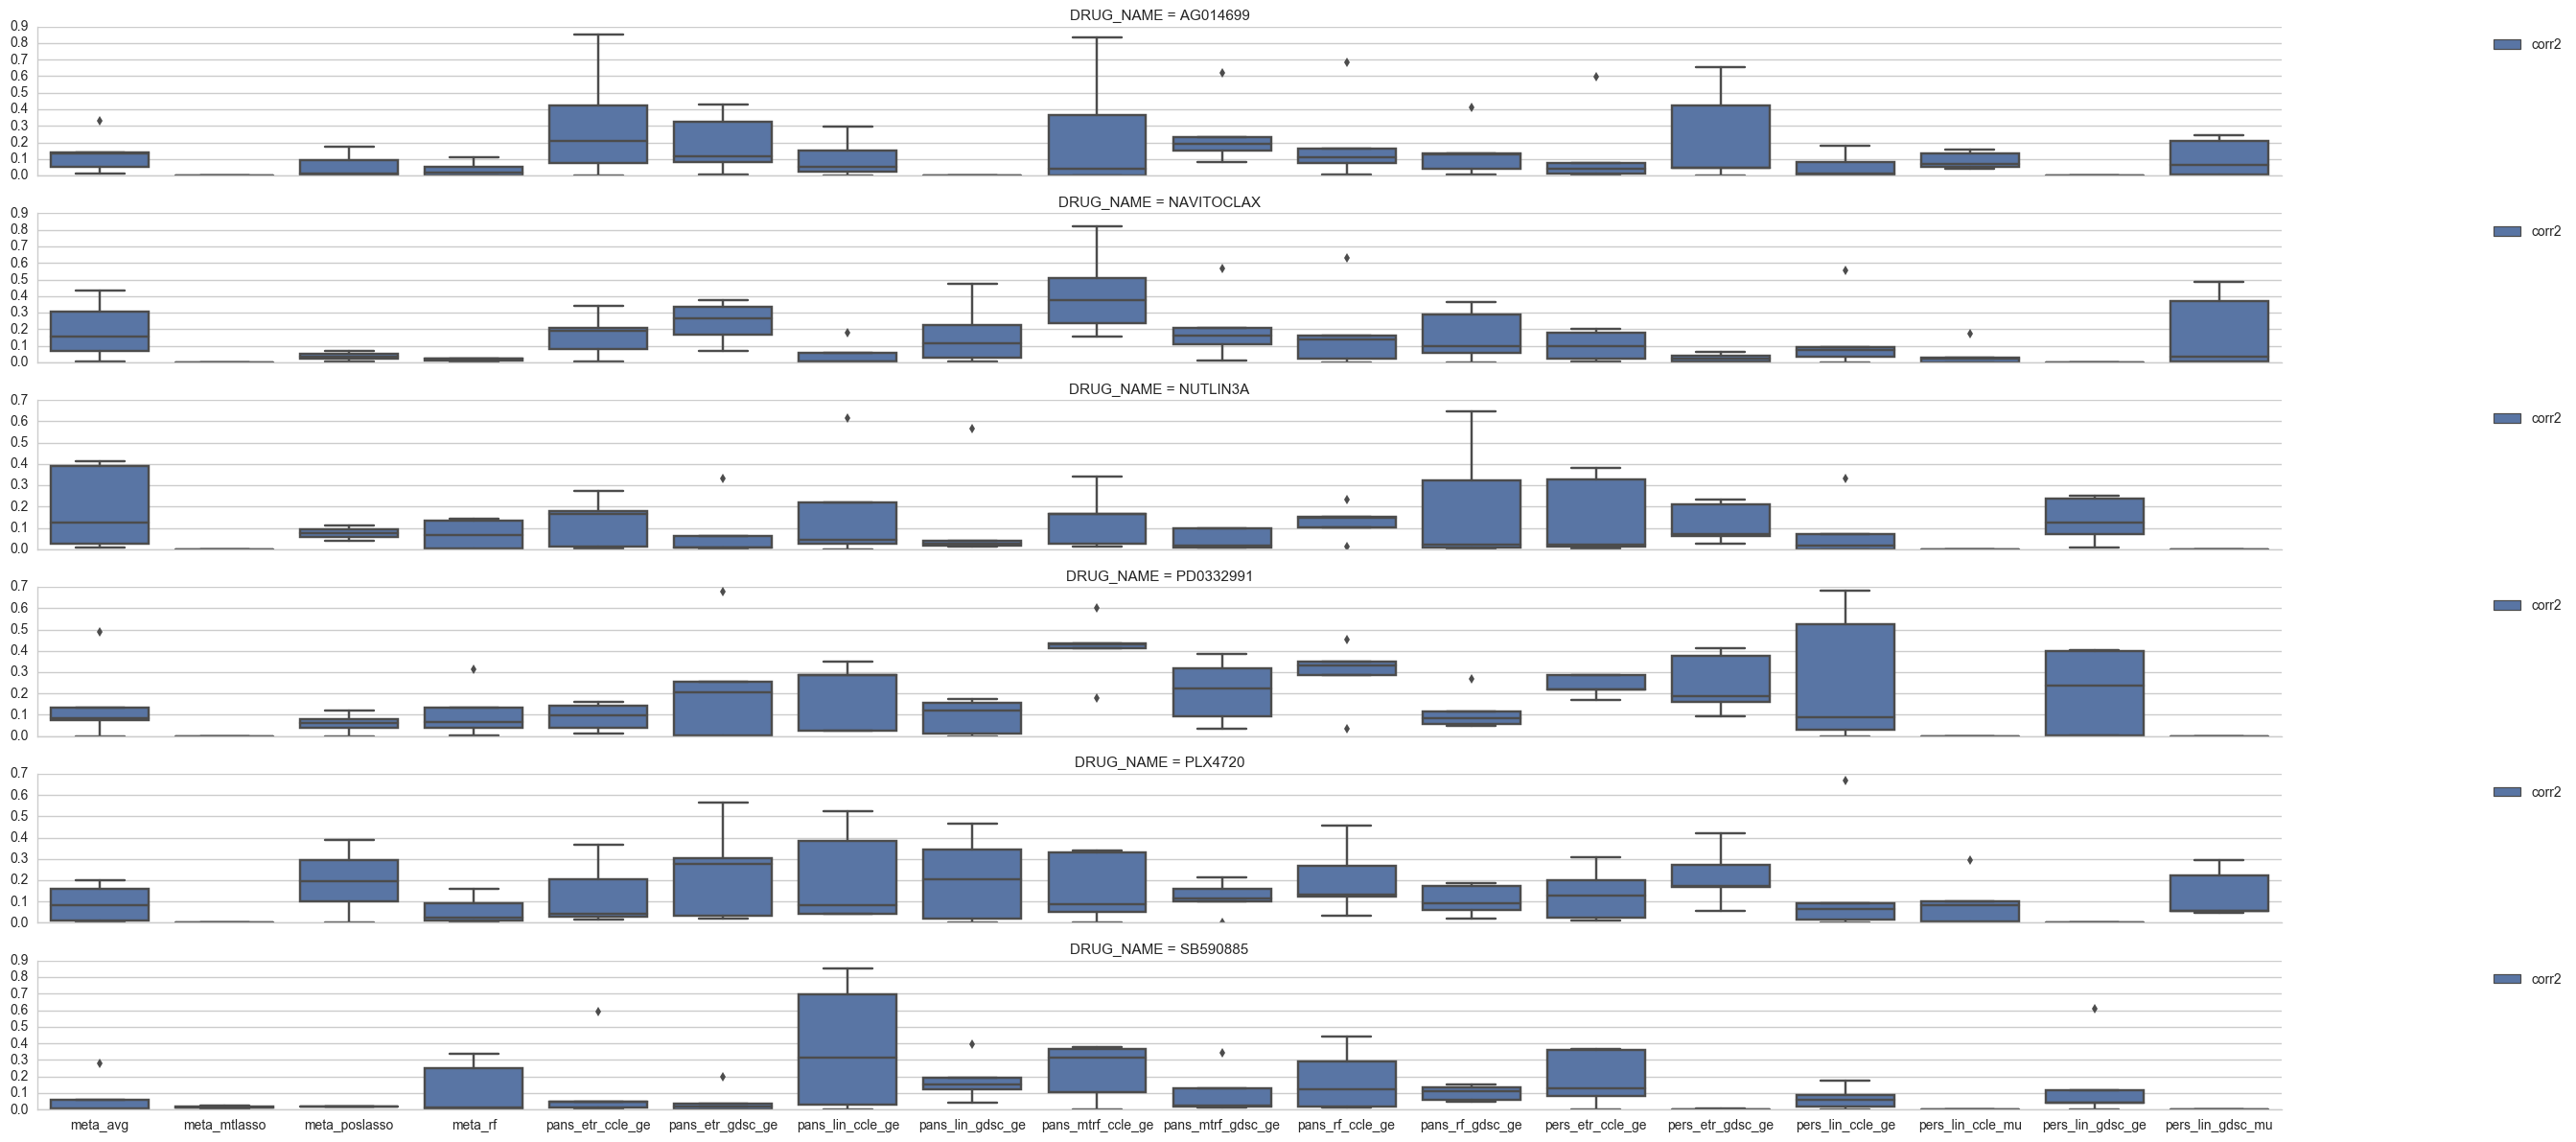

In [102]:
d_pred = res[site]['prediction_data']
score_functions = {
    #'r2': r2_score,
    'corr2': lambda y_true, y_pred: y_pred.corr(y_true)**2,
    #'mse': mean_squared_error
}
d_score = rx_train.get_scores(d_pred, score_functions)
plot_scores(d_score, figaspect=12)

In [52]:
d_pred.columns.tolist()

[('gdsc_v2', 'drug-sensitivity', 'NAVITOCLAX', 'pers_st_lasso_gdsc_mu'),
 ('gdsc_v2', 'drug-sensitivity', 'NILOTINIB', 'pers_st_lasso_gdsc_mu'),
 ('gdsc_v2', 'drug-sensitivity', 'VORINOSTAT', 'pers_st_lasso_gdsc_mu'),
 ('ctd_v2', 'drug-sensitivity', 'VORINOSTAT', 'pers_st_lasso_gdsc_mu'),
 ('ctd_v2', 'drug-sensitivity', 'NILOTINIB', 'pers_st_lasso_gdsc_mu'),
 ('ctd_v2', 'drug-sensitivity', 'NAVITOCLAX', 'pers_st_lasso_gdsc_mu'),
 ('gdsc_v2', 'drug-sensitivity', 'NAVITOCLAX', 'pers_std_etr_ccle_ge'),
 ('gdsc_v2', 'drug-sensitivity', 'NILOTINIB', 'pers_std_etr_ccle_ge'),
 ('gdsc_v2', 'drug-sensitivity', 'VORINOSTAT', 'pers_std_etr_ccle_ge'),
 ('ctd_v2', 'drug-sensitivity', 'VORINOSTAT', 'pers_std_etr_ccle_ge'),
 ('ctd_v2', 'drug-sensitivity', 'NILOTINIB', 'pers_std_etr_ccle_ge'),
 ('ctd_v2', 'drug-sensitivity', 'NAVITOCLAX', 'pers_std_etr_ccle_ge'),
 ('gdsc_v2', 'drug-sensitivity', 'NAVITOCLAX', 'pers_std_etr_gdsc_ge'),
 ('gdsc_v2', 'drug-sensitivity', 'NILOTINIB', 'pers_std_etr_gdsc_ge'

In [80]:

def plot_predictions(d_pred, share_axes=False):
    c_actual = [c for c in d_pred if c[-1] == 'Actual']
    c_pred = d_pred.columns.difference(c_actual)
    
    d = []
    for c_act in c_actual:
        drug_name = c_act[0] + ':' + c_act[-2]
        c_drug_pred = [c for c in c_pred if c[-2] == c_act[-2] and c[0] == c_act[0]]
        for c_pre in c_drug_pred:
            model_name = c_pre[-1]
            d.append(pd.DataFrame({
                'Predicted': d_pred[c_pre],
                'Actual': d_pred[c_act],
                'Drug': drug_name,
                'Model': model_name,
                'Fold': d_pred.index.get_level_values('FOLD_ID')
            }))
        
    d = pd.concat(d)
    g = sns.FacetGrid(
            d, row='Drug', col='Model', hue='Fold', margin_titles=True, size=5, aspect=1,
            sharex=share_axes, sharey=share_axes)
    #g.map(sns.regplot, 'Predicted', 'Actual')
    g.map(plt.scatter, 'Predicted', 'Actual')
    return g, d

grid, d_plt = plot_predictions(d_pred)

In [ ]:
sns.regplot

In [68]:
xx = np.arange(1, 10)
yx = xx * 1 + np.random.rand(len(xx))
r2_score(xx, yx)

0.97001348752971261